In [118]:
import pickle
import numpy as np
from scipy import stats
from sklearn.mixture import GaussianMixture
from sklearn.metrics import auc

# データセットのロード
def load(mode=100):
    """
    pred_val: 1000, 400
    y_val: 1000, 400
    y_dct: ['model', 'year'] 1000
    pred_val_norm: 1000, 400
    y_val_norm: 1000, 400
    """
    # load y_val of label
    testdir = '/docker/mnt/d/research/D2/cnn3/test'
    val_path = testdir + '/continuous/seed1_predictors_coarse_std_Apr_msot-pr_1x1_std_MJJASO_thailand.pickle'
    with open(val_path, 'rb') as f:
        data = pickle.load(f)
    y_val, val_dct = data['y_val'], data['val_dct']
    val_model, val_year = val_dct['model'], val_dct['year'] # validationモデルと年のdict

    # pred_val of svd
    pred_path = f"/docker/mnt/d/research/D2/cnn3/result/svd/thailand/1x1/seed1_mode{mode}.npy"
    pred_val = np.load(pred_path)

    # pred_val_norm, y_val_norm
    pred_norm_path = f"/docker/mnt/d/research/D2/cnn3/result/svd/thailand/1x1/seed1_mode{mode}_norm.pickle"
    with open(pred_norm_path, 'rb') as f:
        data = pickle.load(f)
    pred_val_norm, y_val_norm = data['pred_val_norm'], data['y_val_norm']
    
    return y_val, val_dct, pred_val, pred_val_norm, y_val_norm

def mae_evaluation(pred, y, val_index=4):
    value = pred[val_index, :] # pred(1000, 400)
    label = y[val_index, :] # y(1000, 400)
    ae = np.abs(value - label)
    ae_flat = ae.reshape(-1)
    mae = np.mean(ae_flat)
    print(f"mae of {val_index} is {mae}")
    return ae_flat
    
def rmse_evaluation(pred, y, lat_grid=20, lon_grid=20):
    rmse_flat = []
    for px in range(len(pred.T)):
        value = pred[:, px] # pred(1000, 400)
        label = y[:, px] # y(1000, 400)
        rmse = np.sqrt(np.mean((value - label)**2))
        rmse_flat.append(rmse)
    rmse_flat = np.array(rmse_flat)
    
    n = len(rmse_flat)
    sample_mean = np.mean(rmse_flat)
    sample_var = stats.tvar(rmse_flat)
    interval = stats.norm.interval(alpha=0.95,
                                  loc=sample_mean,
                                  scale=np.sqrt(sample_var/n))
    print(f"rmse_95%reliable_mean {sample_mean} spans {interval}")
    
    rmse_map = rmse_flat.reshape(lat_grid, lon_grid)
    return rmse_map

def GMM(data):
    gmm = GaussianMixture(n_components=2, random_state=42)
    gmm.fit(data.reshape(-1, 1)) # reshape for making dimentions to two
    estimated_group = gmm.predict(data.reshape(-1, 1))
    return gmm

def true_false_bar(pred, y, criteria=0):
    true_count, false_count = 0, 0
    rmse_flat = []
    for sam in range(len(y)):
        value = pred[sam, :] # pred(1000, 400)
        label = y[sam, :] # y(1000, 400)
        rmse = np.sqrt(np.mean((value - label)**2))
        rmse_flat.append(rmse)
    
    rmse_flat = np.array(rmse_flat)
    gmm = GMM(rmse_flat)
    criteria = np.mean([gmm.means_[0, -1],
                        gmm.means_[1, -1]])
    for sam in range(len(y)):
        if rmse_flat[sam] <= criteria:
            true_count += 1
        else:
            false_count += 1
    
    print(f"criteria(mean of gmm) is {criteria}")
    return rmse_flat, gmm, true_count, false_count

def roc(sim, obs, percentile=20):
    """
    this roc function just returns single event 
    if multiple events are needed to be evaluated,
    call auc function below
    """
    # percentile should be absolute number
    sim = np.abs(sim)
    obs = np.abs(obs)
    
    # make criteria
    sim_per = np.percentile(sim, percentile)
    obs_per = np.percentile(obs, percentile)
    
    # calculate number hit and false pixcel
    over_per = sum(obs > obs_per)
    under_per = sum(obs <= obs_per)
    
    # save count of hit a nd false pixcel
    hit_count = 0
    false_count = 0
    for p in range(len(obs)):
        if sim[p] > sim_per and obs[p] > obs_per:
            hit_count += 1
        elif sim[p] > sim_per and obs[p] <= obs_per:
            false_count += 1
    
    # calculate HitRate(TruePositive) and FalseAlertRate(FalsePositive)
    hr = hit_count/over_per
    far = false_count/under_per
    return hr, far

def auc_sample_mean(sims, obses):
    """
    input: validation sample
        Calculate based on percentile of 1000 validation samples in each pixcel
        pred -> sims: (1000, 400)
        y_val -> obses: (1000, 400)
    output: AUC of pixcel map
    
    number of AUC -> pixcel map
    """
    # percentile variation list
    per_list = np.arange(10, 100, 10) # 10...90
    per_list = per_list[::-1]
    
    # result(11, 2, 400) -> (percentile, hr or far, pixcel)
    result = []
    
    # initialize hr & far
    hr_all, far_all = [], []
    for i in range(len(obses.T)):
        hr_all.append(0)
        far_all.append(0)
    result.append([hr_all, far_all])
    
    # different percentile hr & far
    for per in per_list:
        # calculate multiple varidation events
        # len=1728
        hr_all, far_all = [], []
        # calculate roc
        for px in range(len(obses.T)):
            hr_n, far_n = roc(sims[:, px],
                              obses[:, px],
                              percentile=per)
            hr_all.append(hr_n)
            far_all.append(far_n)
        result.append([hr_all, far_all])
        
    # summerize hr & far
    hr_all, far_all = [], []
    for i in range(len(obses.T)):
        hr_all.append(1)
        far_all.append(1)
    result.append([hr_all, far_all])
    
    # result(11, 2, 400)
    result = np.array(result)
    
    # calculate auc_all
    auc_all = []
    for px in range(len(obses.T)):
        fpr = result[:, 1, px]
        fpr = np.sort(fpr)
        tpr = result[:, 0, px]
        tpr = np.sort(tpr)
        AUC = auc(fpr, tpr)
        auc_all.append(AUC)
    auc_all = np.array(auc_all)
    
    # calculate 95% intervals
    n = len(auc_all)
    sample_mean = np.mean(auc_all)
    sample_var = stats.tvar(auc_all)
    interval = stats.norm.interval(alpha=0.95,
                                   loc=sample_mean,
                                   scale=np.sqrt(sample_var/n))
    print(f"auc_95%reliable_mean {sample_mean} spans {interval}")
    
    # hr_mean(11), far_mean(11)
    hr_mean = np.mean(result[:, 0, :], axis=1)
    far_mean = np.mean(result[:, 1, :], axis=1)
    result_mean = np.array([hr_mean, far_mean])
    result_mean = result_mean.T # (11, 2)
    
    return result, result_mean, auc_all

def correlation(pred, y_val, grid_num=400, lat_grid=20, lon_grid=20):
    corr = []
    pred_arr = np.squeeze(pred)
    for i in range(grid_num):
        corr_i = np.corrcoef(pred_arr[:, i], y_val[:, i])
        corr.append(np.round(corr_i[0, 1], 2))
        
    # calculate 95% intervals
    n = len(corr)
    sample_mean = np.mean(corr)
    sample_var = stats.tvar(corr)
    interval = stats.norm.interval(alpha=0.95,
                                   loc=sample_mean,
                                   scale=np.sqrt(sample_var/n))
    print(f"corr_95%reliable_mean{sample_mean} spans {interval}")
    
    # view corr heat-map
    corr = np.array(corr)
    corr = corr.reshape(lat_grid, lon_grid)
    return corr
            
        
    
    
    for i in per_list:
        hr_all, far_all = [], []
        for j in range(len(obses)):
            hr_n, far_n = roc(sims[j], 
                              obses[j], 
                              percentile=i)
            hr_all.append(hr_n)
            far_all.append(far_n)
        hr, far = np.mean(hr_all), np.mean(far_all)
        result.append([hr, far])
    
    result.append([1,1])
    result = np.array(result)
    return result

In [131]:
import cartopy.crs as ccrs
import matplotlib as mpl
import matplotlib.pyplot as plt
import colormaps as clm
from sklearn.metrics import auc
from scipy.stats import norm

def acc_map(acc, vmin=0.75, vmax=1.00, discrete=5):
    projection = ccrs.PlateCarree(central_longitude=180)
    img_extent = (-90, -70, 5, 25) 
    
    mpl.colormaps.unregister('tmp')
    mpl.colormaps.register(clm.temps, name='tmp')
    cm = plt.cm.get_cmap('tmp', discrete)
    
    fig = plt.figure()
    ax = plt.subplot(projection=projection)
    ax.coastlines()
    mat = ax.matshow(acc,
                     origin='upper',
                     extent=img_extent,
                     transform=projection,
                     vmin=vmin,
                     vmax=vmax,
                     cmap=cm)
    fig.colorbar(mat, ax=ax)
    plt.show()
    
def AE_bar(data, vmin=0, vmax=10):
    """
    at every grid
    abs ( real label - prediction) is caluclated
    """
    fig = plt.figure()
    ax = plt.subplot()
    pixcel = np.arange(len(data))
    ax.bar(pixcel, data, color='darkseagreen')
    ax.set_ylim(vmin, vmax)
    plt.show()
    
def bimodal_dist(data, gmm):
    fig, ax = plt.subplots()
    
    # histgram
    ax.hist(data, bins=1000, color='lightsteelblue', alpha=0.8)
    
    # gaussian mixture modelling
    ax2 = ax.twinx()
    x = np.linspace(0, 1, 1000)
    true = norm.pdf(x,
                    gmm.means_[0, -1],
                    np.sqrt(gmm.covariances_[0]))
    false = norm.pdf(x,
                     gmm.means_[1, -1],
                     np.sqrt(gmm.covariances_[1]))
    ax2.plot(x,
             np.squeeze(gmm.weights_[0]*true),
             color='darkslategray',
             label='true')
    ax2.plot(x,
             np.squeeze(gmm.weights_[0]*false),
             color='darkgoldenrod',
             label='false')
    ax2.legend()
    plt.show()
    
def TF_bar(true_count, false_count):
    fig = plt.figure()
    ax = plt.subplot()
    print(f"ture: over_criteria_count {true_count}, false: under_criteria_count {false_count}")
    ax.barh(1,
            true_count,
            height=0.5,
            color='darkslategray',
            align='center',
            label=f"True({true_count})")
    ax.barh(1,
            false_count,
            left=true_count,
            height=0.5,
            color='darkgoldenrod',
            align='center',
            label=f"False({false_count})")
    ax.set_ylim(0, 2)
    ax.set_yticks([1.0], ['validation(1000smples)'])
    plt.legend()
    plt.show()

def draw_roc_curve(roc):
    # calculate auc
    fpr = roc[:, 1]
    tpr = roc[:, 0]
    AUC = auc(fpr, tpr)
    
    fig, ax = plt.subplots(figsize=(6, 6))
    
    plt.plot(fpr,
             tpr,
             label=f"svd ROC curve (AUC = {AUC})",
             color="blueviolet",
             linestyle=":",
             linewidth=4)
    plt.scatter(fpr, tpr, marker='d', s=100, color='blue')
    
    plt.plot([0,1],
             [0,1],
             "k--",
             label="ROC curve for chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

In [132]:
y_val, val_dct, pred_val, pred_val_norm, y_val_norm = load(mode=100)
print(y_val.shape, pred_val.shape)

(1000, 400) (1000, 400)


mae of 4 is 0.9370655554736759


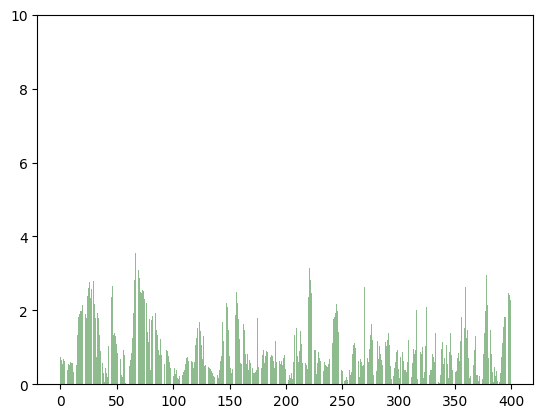

In [133]:
ae_flat = mae_evaluation(pred_val, y_val)
AE_bar(ae_flat)

rmse_95%reliable_mean 1.0815891103099298 spans (1.0766463711266674, 1.0865318494931921)


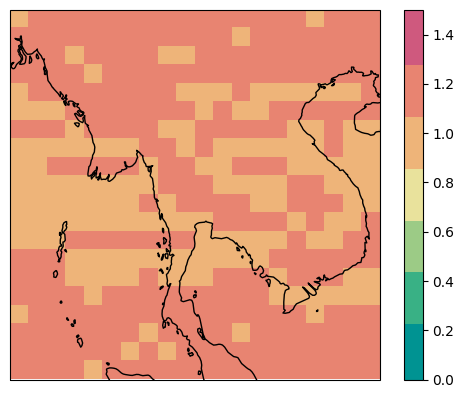

In [134]:
rmse_all = rmse_evaluation(pred_val, y_val)
acc_map(rmse_all, vmin=0, vmax=1.5, discrete=100)

corr_95%reliable_mean-0.0024 spans (-0.005261095864022253, 0.00046109586402225426)


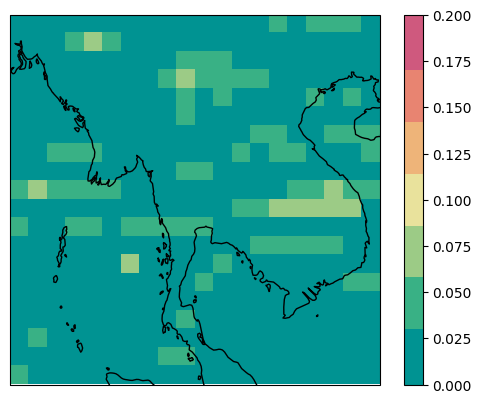

In [135]:
corr_all = correlation(pred_val, y_val)
acc_map(corr_all, vmin=0, vmax=0.2, discrete=100)

criteria(mean of gmm) is 1.0865405399041377


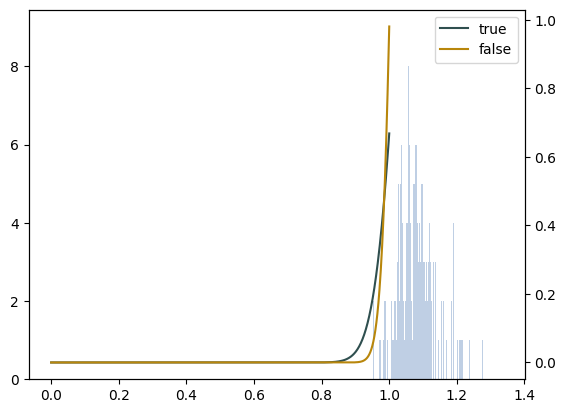

ture: over_criteria_count 578, false: under_criteria_count 422


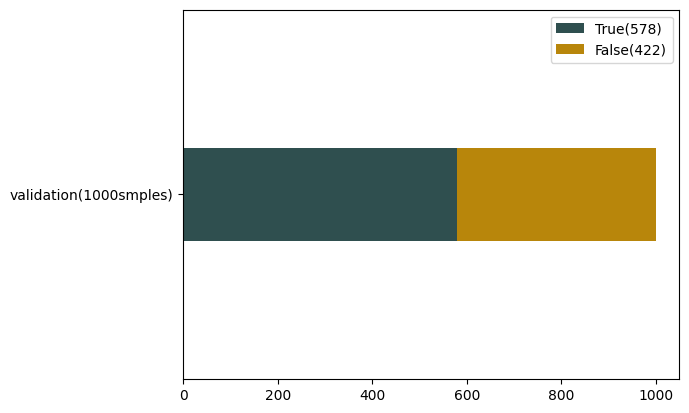

In [136]:
rmse_flat, gmm, true_count, false_count = true_false_bar(pred_val, y_val)
bimodal_dist(rmse_flat, gmm)
TF_bar(true_count, false_count)

# AUC & ROC EVALUATiON

auc_95%reliable_mean 0.5011682002979327 spans (0.4995179340116319, 0.5028184665842336)


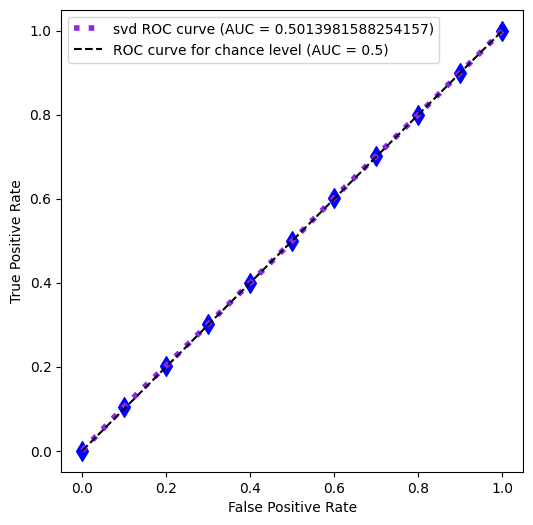

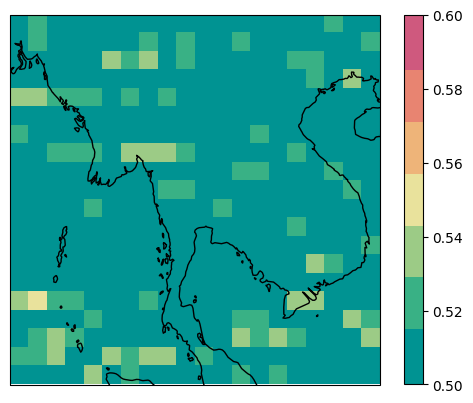

In [137]:
# 普通バージョンのプロット
result, result_mean, auc_all = auc_sample_mean(pred_val, y_val)
draw_roc_curve(result_mean)
acc_map(auc_all.reshape(20,20),
        vmin=0.5,
        vmax=0.6,
        discrete=100)

auc_95%reliable_mean 0.5012327934524007 spans (0.4996773282422478, 0.5027882586625535)


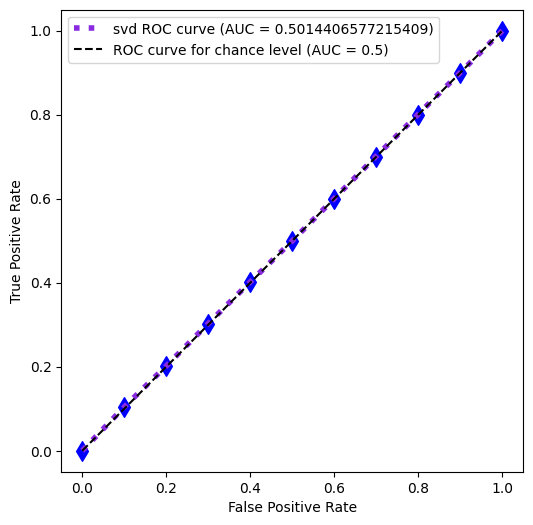

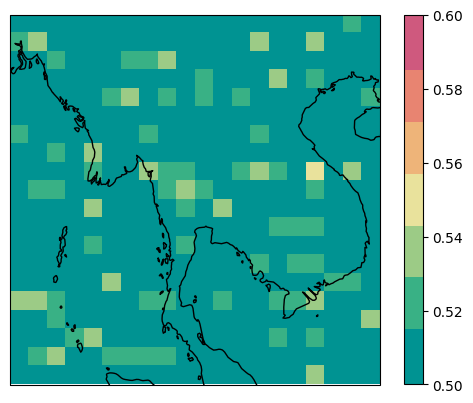

In [138]:
result_norm, result_mean_norm, auc_all_norm = auc_sample_mean(pred_val_norm, y_val_norm)
draw_roc_curve(result_mean_norm)
acc_map(auc_all_norm.reshape(20,20), 
        vmin=0.5,
        vmax=0.6,
        discrete=100)